In [1]:
import spikeinterface.full as si
import probeinterface as pif
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import os

In [2]:
npx_path = os.path.join('E:', 'Dropbox (Dartmouth College)', 'NSB2023', '23242', '01_7_6_23', 'HC101_23242_g0')

In [4]:
si.get_neo_streams('spikeglx',npx_path)

(['imec0.ap', 'nidq', 'imec0.lf'], ['imec0.ap', 'nidq', 'imec0.lf'])

In [6]:
raw_rec = si.read_spikeglx(npx_path, stream_name='imec0.ap')
lfp = si.read_spikeglx(npx_path, stream_name='imec0.lf')
ttls = si.read_spikeglx(npx_path, stream_name='nidq')

In [7]:
this_probe = raw_rec.get_probe()

(<matplotlib.collections.PolyCollection at 0x2587a2cff10>,
 <matplotlib.collections.PolyCollection at 0x28aadab72b0>)

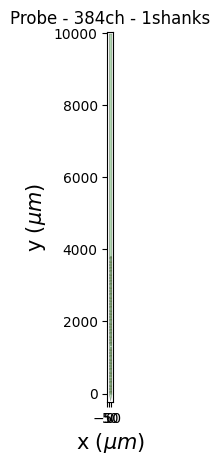

In [8]:
pif.plotting.plot_probe(this_probe)

In [19]:
this_ids = ['nidq#XA1', 'nidq#XA2', 'nidq#XA6']
this_gain = [ttls.get_channel_property(channel_id=x, key='gain_to_uV') for x in this_ids]
this_offset = [ttls.get_channel_property(channel_id=x, key='offset_to_uV') for x in this_ids]

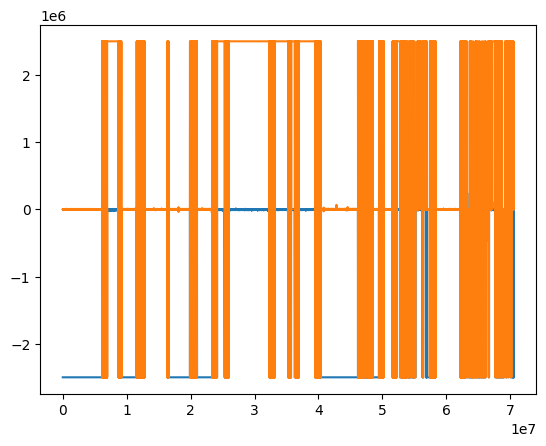

In [12]:
# TODO Plot quadrature signals and decoded speed
plt.plot(ttls.get_traces(channel_ids=[this_ids[0]])*this_gain[0] + this_offset[0])
plt.plot(ttls.get_traces(channel_ids=[this_ids[1]])*this_gain[1] + this_offset[1])

# Plotting the Odor indicator to see how to threshold

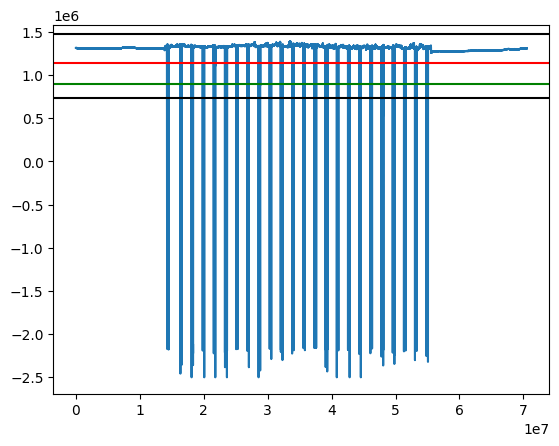

In [39]:
this_signal = ttls.get_traces(channel_ids=[this_ids[2]])*this_gain[2] + this_offset[2]
plt.plot(this_signal) #20070000:20080000 to look at one jump
plt.axhline(np.mean(this_signal) + np.std(this_signal), color='black')
plt.axhline(np.mean(this_signal) - np.std(this_signal), color='red')
plt.axhline(np.mean(this_signal) - 2.5*np.std(this_signal), color='green')
plt.axhline(np.mean(this_signal) - 3.5*np.std(this_signal), color='black')

In [ ]:
# function to find the indices of this_signal that are less than mean - 1.5*std, such that the previous index was greater than mean - 1.5*std
def find_jumps(signal):
    np.w

(-100.0, 4000.0)

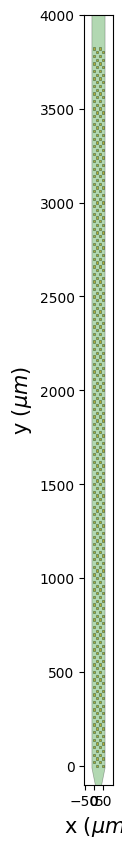

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=False)
ax.set_ylim(-100, 4000)

In [41]:
bad_channel_ids, channel_labels = si.detect_bad_channels(raw_rec)

In [43]:
bad_channel_ids

array(['imec0.ap#AP28', 'imec0.ap#AP80', 'imec0.ap#AP116',
       'imec0.ap#AP143', 'imec0.ap#AP144', 'imec0.ap#AP191',
       'imec0.ap#AP239'], dtype='<U64')

In [46]:
raw_rec._annotations

{'is_filtered': False,
 'probe_0_planar_contour': array([[ -11, 9989],
        [ -11,  -11],
        [  24, -186],
        [  59,  -11],
        [  59, 9989]]),
 'probes_info': [{'name': 'Neuropixels 1.0',
   'manufacturer': 'IMEC',
   'probe_type': 0}]}

In [47]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec = rec4

bad_channel_ids ['imec0.ap#AP28' 'imec0.ap#AP80' 'imec0.ap#AP116' 'imec0.ap#AP143'
 'imec0.ap#AP144' 'imec0.ap#AP191' 'imec0.ap#AP239']


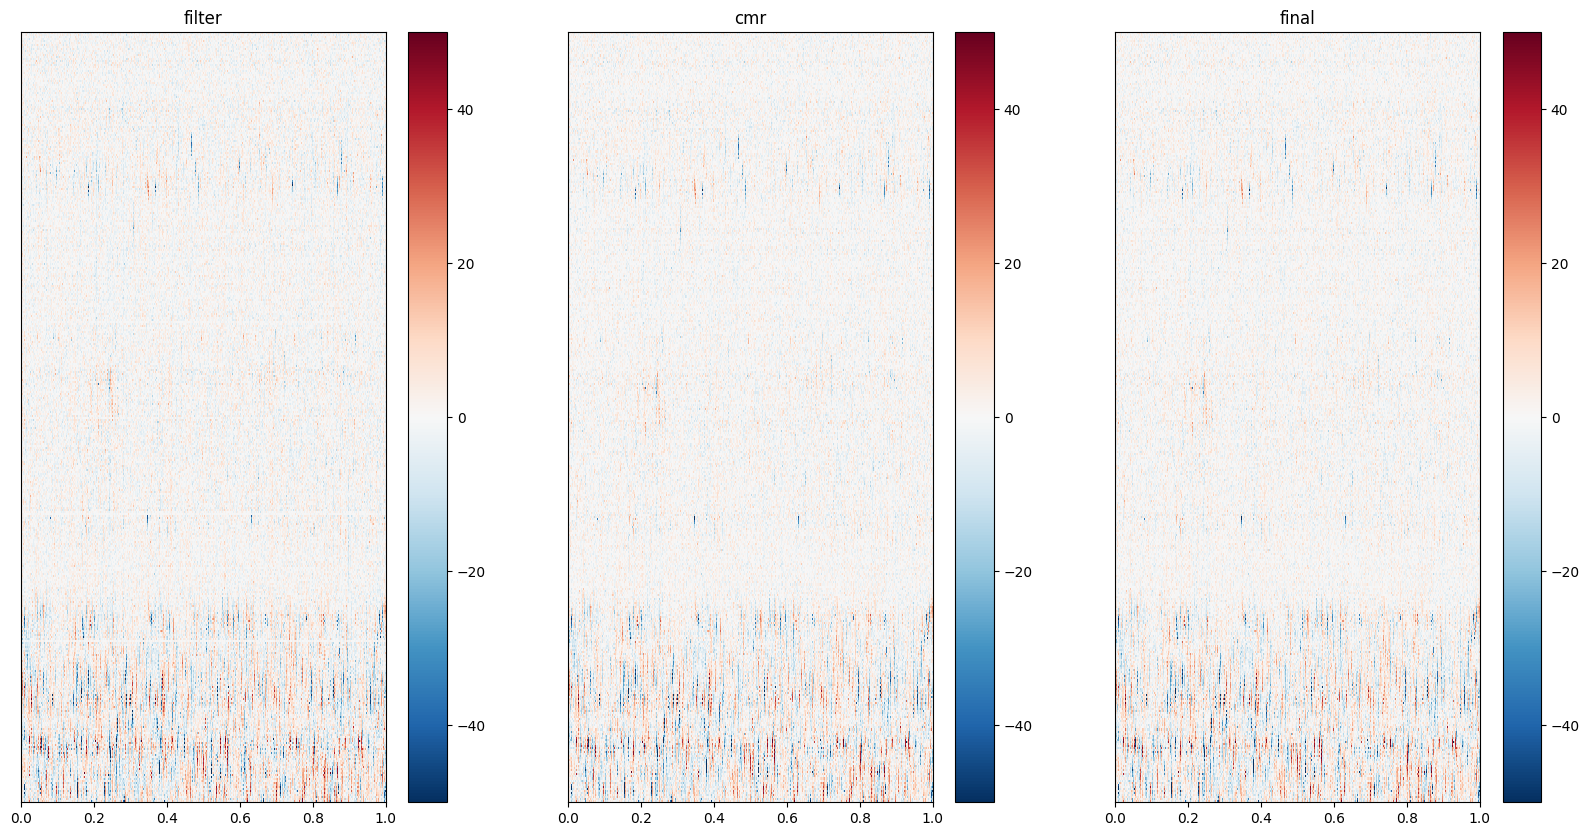

In [58]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

si.plot_timeseries(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_timeseries(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_timeseries(rec, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'cmr', 'final')):
    axs[i].set_title(label)
    

Text(0.5, 0, 'noise  [microV]')

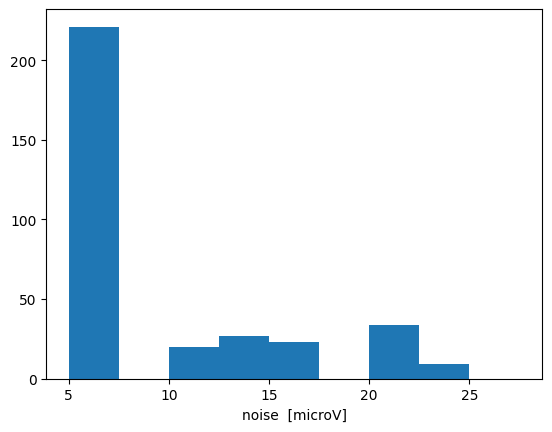

In [59]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec4, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec4, return_scaled=False)

fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [microV]')



In [60]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec4,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, local_radius_um=50., **job_kwargs)
peaks

In [56]:
%matplotlib inline